In [2]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------- ----------- 1.0/1.5 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 5.9 MB/s  0:00:00


In [4]:
# %% [markdown]
# # Deterioration Risk Prediction Pipeline
# - Input: 30–180 days of patient history (daily timelines)
# - Output: probability of deterioration in next 90 days
# - Steps: simulate/load data → feature engineering → train/test → eval → explainability (SHAP)

# %% [code]
import os
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, brier_score_loss
from sklearn.calibration import calibration_curve
import joblib

# modeling
import lightgbm as lgb

# SHAP
import shap

# other utils
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8,5)


In [6]:
# %% [markdown]
# ## 2.1 Simulate a patient-level daily timeline dataset
# We'll simulate vitals, labs, medication adherence and lifestyle data for multiple patients.
# Each patient gets a timeline of daily records (30–180 days). We'll also simulate a binary label:
# whether the patient deteriorated in the next 90 days (0/1).
# This is only for prototyping — replace with real dataset later.

# %% [code]
def simulate_patient_timeline(n_patients=1000, min_days=30, max_days=180, seed=42):
    np.random.seed(seed)
    rows = []
    for pid in range(1, n_patients+1):
        days = np.random.randint(min_days, max_days+1)
        start_date = pd.Timestamp("2023-01-01") + pd.Timedelta(days=np.random.randint(0,365))
        dates = [start_date + pd.Timedelta(days=i) for i in range(days)]
        # baseline patient properties
        age = np.random.randint(30, 90)
        sex = np.random.choice(['M','F'])
        baseline_hba1c = np.clip(np.random.normal(6.5, 1.0), 4.5, 12.0)
        baseline_bp = np.clip(np.random.normal(130, 15), 90, 220)
        deteriorate_flag = np.random.binomial(1, 0.08)  # rare event
        for d in dates:
            # vitals/labs with trends/noise
            # introduce higher chance of rising labs if deteriorating
            trend = 0.02 * max(0, (d - dates[0]).days) / 30.0
            hba1c = baseline_hba1c + np.random.normal(0, 0.2) + (0.4 if deteriorate_flag and np.random.rand()<0.5 else 0) * trend
            systolic_bp = baseline_bp + np.random.normal(0, 8) + (5 if deteriorate_flag and np.random.rand()<0.3 else 0) * trend
            weight = np.clip(np.random.normal(70, 10) + (2 if deteriorate_flag and np.random.rand()<0.3 else 0)*trend, 40, 160)
            steps = max(0, int(np.random.normal(6000, 2000) - (1000 if deteriorate_flag and np.random.rand()<0.4 else 0)))
            sleep = max(3, np.random.normal(7, 1.0) - (0.5 if deteriorate_flag and np.random.rand()<0.3 else 0))
            # medication adherence: 1=day dose taken, 0=missed; more misses if deteriorating
            med_taken = np.random.binomial(1, 0.95 - 0.15 * deteriorate_flag)
            # missingness: some days no vitals recorded
            recorded = np.random.binomial(1, 0.98 if np.random.rand()>0.05 else 0.6)
            rows.append({
                "patient_id": f"P{pid}",
                "date": d,
                "age": age,
                "sex": sex,
                "hba1c": hba1c if recorded else np.nan,
                "systolic_bp": systolic_bp if recorded else np.nan,
                "weight": weight if recorded else np.nan,
                "steps": steps if recorded else np.nan,
                "sleep_hours": sleep if recorded else np.nan,
                "med_taken": med_taken if recorded else np.nan,
                "deteriorated_in_next_90d": deteriorate_flag
            })
    df = pd.DataFrame(rows)
    # shuffle
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    return df

# create synthetic data
df = simulate_patient_timeline(n_patients=800, min_days=60, max_days=180, seed=2025)
df.head()


,patient_id,date,age,sex,hba1c,systolic_bp,weight,steps,sleep_hours,med_taken,deteriorated_in_next_90d
0,P269,2023-06-26,63,M,7.010361,132.908975,73.410854,5390.0,8.182543,1.0,0
1,P799,2023-10-22,71,M,6.065644,130.981992,64.137363,5486.0,5.910420,1.0,0
2,P211,2023-05-31,72,F,5.575736,111.810769,71.822952,6956.0,7.530055,1.0,0
3,P249,2024-02-10,32,F,5.286635,138.312960,69.888162,7382.0,7.317678,1.0,0
4,P100,2023-05-24,68,F,7.094159,127.791646,81.539825,4371.0,4.968403,1.0,0


In [7]:
# create synthetic data
df = simulate_patient_timeline(n_patients=800, min_days=60, max_days=180, seed=2025)

# save to CSV
df.to_csv("synthetic_patient_data.csv", index=False)

df.head()


,patient_id,date,age,sex,hba1c,systolic_bp,weight,steps,sleep_hours,med_taken,deteriorated_in_next_90d
0,P269,2023-06-26,63,M,7.010361,132.908975,73.410854,5390.0,8.182543,1.0,0
1,P799,2023-10-22,71,M,6.065644,130.981992,64.137363,5486.0,5.910420,1.0,0
2,P211,2023-05-31,72,F,5.575736,111.810769,71.822952,6956.0,7.530055,1.0,0
3,P249,2024-02-10,32,F,5.286635,138.312960,69.888162,7382.0,7.317678,1.0,0
4,P100,2023-05-24,68,F,7.094159,127.791646,81.539825,4371.0,4.968403,1.0,0


In [8]:
# %% [code]
# Run if you don't have the packages installed in the notebook environment
!pip install numpy pandas scikit-learn matplotlib seaborn lightgbm shap joblib --quiet
print("Install (or verify) done.")


Install (or verify) done.


In [9]:
# %% [code]
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix, brier_score_loss
from sklearn.calibration import calibration_curve
from lightgbm import LGBMClassifier
import shap
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [10]:
# %% [code]
# change this path if your csv is in a subfolder
possible_paths = ["synthetic_patient_data.csv", "data/synthetic_patient_data.csv"]
csv_path = next((p for p in possible_paths if os.path.exists(p)), None)

if csv_path is None:
    raise FileNotFoundError("Could not find 'synthetic_patient_data.csv' in the current folder or 'data/'. "
                            "Please update the path to your CSV.")

df = pd.read_csv(csv_path, parse_dates=['date'])
print("Loaded:", csv_path)
print("shape:", df.shape)
display(df.head())


Loaded: synthetic_patient_data.csv
shape: (95475, 11)


,patient_id,date,age,sex,hba1c,systolic_bp,weight,steps,sleep_hours,med_taken,deteriorated_in_next_90d
0,P269,2023-06-26,63,M,7.010361,132.908975,73.410854,5390.0,8.182543,1.0,0
1,P799,2023-10-22,71,M,6.065644,130.981992,64.137363,5486.0,5.910420,1.0,0
2,P211,2023-05-31,72,F,5.575736,111.810769,71.822952,6956.0,7.530055,1.0,0
3,P249,2024-02-10,32,F,5.286635,138.312960,69.888162,7382.0,7.317678,1.0,0
4,P100,2023-05-24,68,F,7.094159,127.791646,81.539825,4371.0,4.968403,1.0,0


Columns: ['patient_id', 'date', 'age', 'sex', 'hba1c', 'systolic_bp', 'weight', 'steps', 'sleep_hours', 'med_taken', 'deteriorated_in_next_90d']

Missing fraction per column:
                          missing_frac
hba1c                         0.037863
systolic_bp                   0.037863
weight                        0.037863
steps                         0.037863
sleep_hours                   0.037863
med_taken                     0.037863
patient_id                    0.000000
date                          0.000000
age                           0.000000
sex                           0.000000
deteriorated_in_next_90d      0.000000

Outcome distribution (per patient-row; may duplicate per day):
deteriorated_in_next_90d
0    0.916575
1    0.083425
Name: proportion, dtype: float64

Unique patients: 800


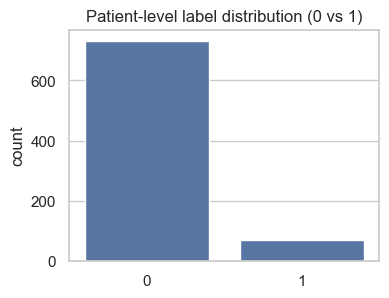

In [11]:
# %% [code]
# Basic checks
print("Columns:", df.columns.tolist())
print("\nMissing fraction per column:")
print((df.isnull().mean()).sort_values(ascending=False).to_frame("missing_frac"))

print("\nOutcome distribution (per patient-row; may duplicate per day):")
print(df['deteriorated_in_next_90d'].value_counts(dropna=False, normalize=True))

# How many unique patients?
print("\nUnique patients:", df['patient_id'].nunique())

# visualize class balance at patient-level
patient_label = df.groupby('patient_id')['deteriorated_in_next_90d'].max()
plt.figure(figsize=(4,3))
sns.countplot(x=patient_label.values)
plt.title("Patient-level label distribution (0 vs 1)")
plt.show()


In [12]:
# %% [code]
def engineer_features(df, window_days=90, as_of_date=None):
    """
    Convert daily timeline -> patient-level features using the last `window_days`.
    Returns a DataFrame indexed by patient_id with a 'label' column.
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    # compute last_date per patient (anchor)
    if as_of_date is None:
        last_dates = df.groupby('patient_id')['date'].max().rename('last_date')
        df = df.merge(last_dates, left_on='patient_id', right_index=True)
    else:
        df['last_date'] = pd.to_datetime(as_of_date)

    df['days_from_last'] = (df['last_date'] - df['date']).dt.days
    df_window = df[df['days_from_last'].between(0, window_days-1)].copy()

    features = []
    numeric_cols_for_trends = ['hba1c','systolic_bp','weight','steps','sleep_hours']

    for pid, g in df_window.groupby('patient_id'):
        g = g.sort_values('date')
        feat = {'patient_id': pid}
        # static
        feat['age'] = g['age'].dropna().iloc[0] if not g['age'].dropna().empty else np.nan
        feat['sex_M'] = 1 if (g['sex'].dropna().iloc[0] == 'M') else 0

        for col in numeric_cols_for_trends:
            s = g[col].dropna()
            feat[f'{col}_last'] = s.iloc[-1] if len(s) > 0 else np.nan
            feat[f'{col}_mean'] = s.mean() if len(s) > 0 else np.nan
            feat[f'{col}_std'] = s.std(ddof=0) if len(s) > 1 else 0.0
            # slope: simple linear fit on index
            if len(s) > 1:
                x = np.arange(len(s))
                y = s.values
                slope = np.polyfit(x, y, 1)[0]
                feat[f'{col}_slope'] = float(slope)
            else:
                feat[f'{col}_slope'] = 0.0
            # delta last - mean
            if pd.notnull(feat[f'{col}_last']):
                feat[f'{col}_delta_last_mean'] = feat[f'{col}_last'] - feat[f'{col}_mean']
            else:
                feat[f'{col}_delta_last_mean'] = np.nan

        # medication adherence
        med = g['med_taken'].dropna()
        feat['med_days_recorded'] = int(len(med))
        feat['med_adherence_prop'] = float(med.mean()) if len(med) > 0 else np.nan
        # longest consecutive miss streak
        if len(med) > 0:
            arr = med.values.astype(int)
            max_streak = 0
            cur = 0
            for v in arr:
                if v == 0:
                    cur += 1
                    if cur > max_streak:
                        max_streak = cur
                else:
                    cur = 0
            feat['med_max_miss_streak'] = int(max_streak)
        else:
            feat['med_max_miss_streak'] = np.nan

        # missingness patterns: how many unique days in window had any vitals recorded
        recorded_mask = g[numeric_cols_for_trends].notna().any(axis=1)
        feat['days_with_any_record'] = int(recorded_mask.sum())
        feat['frac_days_recorded'] = feat['days_with_any_record'] / float(window_days)

        # num rows present in window
        feat['num_records_in_window'] = int(g.shape[0])

        # label (assumes label is per patient same value)
        feat['label'] = int(g['deteriorated_in_next_90d'].max()) if 'deteriorated_in_next_90d' in g else 0

        features.append(feat)

    feats_df = pd.DataFrame(features).set_index('patient_id')
    return feats_df

# create features (you can change window_days to 30/60/120 as needed)
feats = engineer_features(df, window_days=90)
print("feature shape:", feats.shape)
display(feats.head())


feature shape: (800, 34)


,age,sex_M,hba1c_last,hba1c_mean,hba1c_std,hba1c_slope,hba1c_delta_last_mean,systolic_bp_last,systolic_bp_mean,systolic_bp_std,...,sleep_hours_std,sleep_hours_slope,sleep_hours_delta_last_mean,med_days_recorded,med_adherence_prop,med_max_miss_streak,days_with_any_record,frac_days_recorded,num_records_in_window,label
patient_id,,,,,,,,,,,,,,,,,,,,,
P1,48,1,6.564376,6.384025,0.198669,0.000356,0.180351,135.727699,141.578996,7.461942,...,0.990887,0.003950,1.372593,86,0.965116,1,86,0.955556,90,0
P10,85,0,5.161804,5.308978,0.195981,-0.000101,-0.147173,156.648309,150.684630,7.821068,...,1.048431,-0.000115,-1.110496,87,0.965517,1,87,0.966667,90,0
P100,68,0,7.302084,7.145890,0.165727,0.000952,0.156194,113.814344,114.869711,8.263829,...,0.921092,0.001813,0.444002,86,0.976744,1,86,0.955556,90,0
P101,37,1,6.734044,6.960011,0.207681,0.001172,-0.225966,141.888404,137.184740,8.325559,...,0.946912,-0.001323,-0.238997,86,0.953488,1,86,0.955556,90,0
P102,80,0,6.893862,6.794758,0.195182,0.000631,0.099104,107.891573,116.432282,9.311595,...,0.986547,0.002162,-0.216903,85,0.952941,1,85,0.944444,90,0


In [13]:
# %% [code]
# Inspect missingness in features
print("Feature missing fractions:")
print(feats.isnull().mean().sort_values(ascending=False).to_frame("missing_frac"))

# Impute numeric columns with median (leave label alone)
feats_filled = feats.copy()
numeric_cols = feats_filled.select_dtypes(include=[np.number]).columns.tolist()
if 'label' in numeric_cols:
    numeric_cols.remove('label')

for c in numeric_cols:
    median_val = feats_filled[c].median()
    feats_filled[c] = feats_filled[c].fillna(median_val)

print("\nAfter imputation missing fractions:")
print(feats_filled.isnull().mean().sort_values(ascending=False).to_frame("missing_frac"))


Feature missing fractions:
                             missing_frac
age                                   0.0
sleep_hours_slope                     0.0
steps_std                             0.0
steps_slope                           0.0
steps_delta_last_mean                 0.0
sleep_hours_last                      0.0
sleep_hours_mean                      0.0
sleep_hours_std                       0.0
sleep_hours_delta_last_mean           0.0
sex_M                                 0.0
med_days_recorded                     0.0
med_adherence_prop                    0.0
med_max_miss_streak                   0.0
days_with_any_record                  0.0
frac_days_recorded                    0.0
num_records_in_window                 0.0
steps_mean                            0.0
steps_last                            0.0
weight_delta_last_mean                0.0
weight_slope                          0.0
weight_std                            0.0
weight_mean                           0.0
weight_

In [14]:
# %% [code]
# X and y (index is patient_id)
X_all = feats_filled.drop(columns=['label'])
y_all = feats_filled['label']

# If labels are extremely imbalanced such that stratify fails (single class), fall back to random split
stratify_vals = y_all.values if len(np.unique(y_all.values)) > 1 else None

train_ids, test_ids = train_test_split(
    X_all.index.values,
    test_size=0.20,
    stratify=stratify_vals,
    random_state=RANDOM_STATE
)

X_train = X_all.loc[train_ids]
y_train = y_all.loc[train_ids]
X_test = X_all.loc[test_ids]
y_test = y_all.loc[test_ids]

print("Train patients:", X_train.shape[0], "| Test patients:", X_test.shape[0])
print("Positive counts (train/test):", int(y_train.sum()), int(y_test.sum()))


Train patients: 640 | Test patients: 160
Positive counts (train/test): 54 14


In [17]:
# %% [code]
def engineer_features(df, window_days=90, as_of_date=None):
    """
    Input: daily timeline df with columns: patient_id, date, vitals..., label column (deteriorated_in_next_90d)
    Output: one row per patient with features computed from last `window_days`
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])

    # choose last date per patient if as_of_date not given
    if as_of_date is None:
        last_dates = df.groupby('patient_id')['date'].max().rename('last_date')
        df = df.merge(last_dates, left_on='patient_id', right_index=True)
    else:
        df['last_date'] = pd.to_datetime(as_of_date)

    # focus on the last window
    df['days_from_last'] = (df['last_date'] - df['date']).dt.days
    df_window = df[df['days_from_last'].between(0, window_days-1)].copy()

    features = []
    for pid, g in df_window.groupby('patient_id'):
        feat = {"patient_id": pid}
        # demographics
        feat['age'] = g['age'].dropna().iloc[0] if not g['age'].dropna().empty else np.nan
        feat['sex_M'] = 1 if g['sex'].dropna().iloc[0] == 'M' else 0

        # vitals/lifestyle features
        for col in ['hba1c', 'systolic_bp', 'weight', 'steps', 'sleep_hours']:
            s = g.sort_values('date')[col].dropna()
            feat[f'{col}_last'] = s.iloc[-1] if len(s) > 0 else np.nan
            feat[f'{col}_mean'] = s.mean() if len(s) > 0 else np.nan
            feat[f'{col}_std'] = s.std() if len(s) > 1 else 0.0
            # slope
            if len(s) > 1:
                x = np.arange(len(s))
                slope = np.polyfit(x, s.values, 1)[0]
                feat[f'{col}_slope'] = slope
            else:
                feat[f'{col}_slope'] = 0.0
            feat[f'{col}_delta_last_mean'] = (
                feat[f'{col}_last'] - feat[f'{col}_mean']
            ) if pd.notnull(feat[f'{col}_last']) else np.nan

        # medication adherence
        med = g.sort_values('date')['med_taken'].dropna()
        feat['med_days_recorded'] = len(med)
        feat['med_adherence_prop'] = med.mean() if len(med) > 0 else np.nan
        if len(med) > 0:
            arr, max_streak, cur = med.values, 0, 0
            for v in arr:
                if v == 0:
                    cur += 1
                    max_streak = max(max_streak, cur)
                else:
                    cur = 0
            feat['med_max_miss_streak'] = max_streak
        else:
            feat['med_max_miss_streak'] = np.nan

        # missingness
        total_days = window_days
        recorded_days = g['hba1c'].notna() | g['systolic_bp'].notna() | g['weight'].notna()
        days_with_record = recorded_days.groupby(g['date']).any().sum() if 'date' in g else recorded_days.sum()
        feat['frac_days_recorded'] = days_with_record / total_days
        feat['num_records'] = g.shape[0]

        # label
        feat['label'] = g['deteriorated_in_next_90d'].max() if 'deteriorated_in_next_90d' in g else 0
        features.append(feat)

    feats_df = pd.DataFrame(features).set_index('patient_id')
    return feats_df

# build features from your synthetic dataset
feats = engineer_features(df, window_days=90)
feats.head()


,age,sex_M,hba1c_last,hba1c_mean,hba1c_std,hba1c_slope,hba1c_delta_last_mean,systolic_bp_last,systolic_bp_mean,systolic_bp_std,...,sleep_hours_mean,sleep_hours_std,sleep_hours_slope,sleep_hours_delta_last_mean,med_days_recorded,med_adherence_prop,med_max_miss_streak,frac_days_recorded,num_records,label
patient_id,,,,,,,,,,,,,,,,,,,,,
P1,48,1,6.564376,6.384025,0.199835,0.000356,0.180351,135.727699,141.578996,7.505707,...,7.009311,0.996699,0.003950,1.372593,86,0.965116,1,0.955556,90,0
P10,85,0,5.161804,5.308978,0.197117,-0.000101,-0.147173,156.648309,150.684630,7.866408,...,7.072903,1.054509,-0.000115,-1.110496,87,0.965517,1,0.966667,90,0
P100,68,0,7.302084,7.145890,0.166699,0.000952,0.156194,113.814344,114.869711,8.312298,...,6.922804,0.926495,0.001813,0.444002,86,0.976744,1,0.955556,90,0
P101,37,1,6.734044,6.960011,0.208899,0.001172,-0.225966,141.888404,137.184740,8.374390,...,7.032920,0.952466,-0.001323,-0.238997,86,0.953488,1,0.955556,90,0
P102,80,0,6.893862,6.794758,0.196340,0.000631,0.099104,107.891573,116.432282,9.366857,...,7.114112,0.992402,0.002162,-0.216903,85,0.952941,1,0.944444,90,0


In [18]:
# %% [code]
# median imputation for numeric columns
numeric_cols = feats.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('label')
feats_filled = feats.copy()
for c in numeric_cols:
    feats_filled[c] = feats_filled[c].fillna(feats_filled[c].median())

# train/test split by patient
X = feats_filled.drop(columns=['label'])
y = feats_filled['label']

# reset index for splitting
X = X.reset_index()
y = y.reset_index(drop=False).set_index('patient_id')['label']

# merge to align
data = X.set_index('patient_id').join(y)
data = data.sample(frac=1, random_state=42)

from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(
    data.index, test_size=0.2, stratify=data['label'], random_state=42
)
X_train = data.loc[train_idx].drop(columns=['label'])
y_train = data.loc[train_idx]['label']
X_test = data.loc[test_idx].drop(columns=['label'])
y_test = data.loc[test_idx]['label']

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Positives in train:", y_train.sum(), "Positives in test:", y_test.sum())


Train size: (640, 32) Test size: (160, 32)
Positives in train: 54 Positives in test: 14


In [19]:
# %% [code]
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

features_list = X_train.columns.tolist()

# inner validation split
stratify_train_vals = y_train if len(y_train.unique()) > 1 else None
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=stratify_train_vals, random_state=42
)

# model
model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    class_weight='balanced'
)

# fit with callbacks
model.fit(
    X_tr[features_list], y_tr,
    eval_set=[(X_val[features_list], y_val)],
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
)

# predict probabilities
probs_test = model.predict_proba(X_test[features_list])[:, 1]
probs_train = model.predict_proba(X_train[features_list])[:, 1]


[LightGBM] [Info] Number of positive: 46, number of negative: 498
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4807
[LightGBM] [Info] Number of data points in the train set: 544, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

Train metrics: {'auc': 1.0, 'auprc': 1.0, 'brier': 0.22564478035516639, 'sensitivity': 1.0, 'specificity': 1.0, 'tn': 586, 'fp': 0, 'fn': 0, 'tp': 54}
Test metrics: {'auc': 0.8860078277886495, 'auprc': 0.6835851648351648, 'brier': 0.22720597950589944, 'sensitivity': 0.7857142857142857, 'specificity': 0.9863013698630136, 'tn': 144, 'fp': 2, 'fn': 3, 'tp': 11}


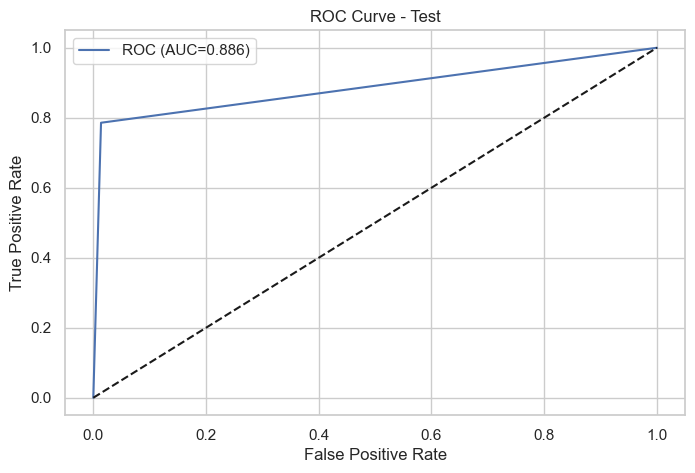

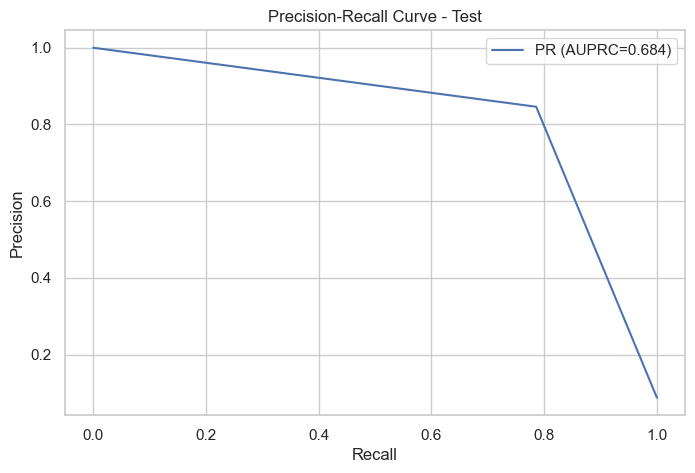

In [20]:
# %% [code]
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt

def evaluate_preds(y_true, probs, thresh=0.5):
    auc = roc_auc_score(y_true, probs)
    auprc = average_precision_score(y_true, probs)
    brier = brier_score_loss(y_true, probs)
    preds = (probs >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return {
        "auc": auc, "auprc": auprc, "brier": brier,
        "sensitivity": sensitivity, "specificity": specificity,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    }

metrics_train = evaluate_preds(y_train, probs_train)
metrics_test = evaluate_preds(y_test, probs_test)

print("Train metrics:", metrics_train)
print("Test metrics:", metrics_test)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, probs_test)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC={metrics_test["auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test')
plt.legend()
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, probs_test)
plt.figure()
plt.plot(recall, precision, label=f'PR (AUPRC={metrics_test["auprc"]:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test')
plt.legend()
plt.show()


In [21]:
# Predict probabilities on test set
probs_test = model.predict_proba(X_test[features_list])[:, 1]  # probability of class 1
preds_test = (probs_test >= 0.5).astype(int)


In [23]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    accuracy_score
)


In [24]:
val_probs = model.predict_proba(X_val[features_list])[:, 1]
val_preds = (val_probs >= 0.5).astype(int)

print("\nValidation Results:")
print("ROC-AUC:", roc_auc_score(y_val, val_probs))
print("PR-AUC:", average_precision_score(y_val, val_probs))
print("F1 Score:", f1_score(y_val, val_preds))
print("Accuracy:", accuracy_score(y_val, val_preds))



Validation Results:
ROC-AUC: 1.0
PR-AUC: 1.0
F1 Score: 1.0
Accuracy: 1.0


In [25]:
import joblib
import pandas as pd

# Save model
joblib.dump(model, "lightgbm_model.pkl")

# Save predictions on test set
output = pd.DataFrame({
    "ID": X_test.index,      # adjust if test set has an ID column
    "prediction": preds_test,
    "probability": probs_test
})
output.to_csv("test_predictions.csv", index=False)

print("\n✅ Model saved as 'lightgbm_model.pkl'")
print("✅ Predictions saved as 'test_predictions.csv'")



✅ Model saved as 'lightgbm_model.pkl'
✅ Predictions saved as 'test_predictions.csv'


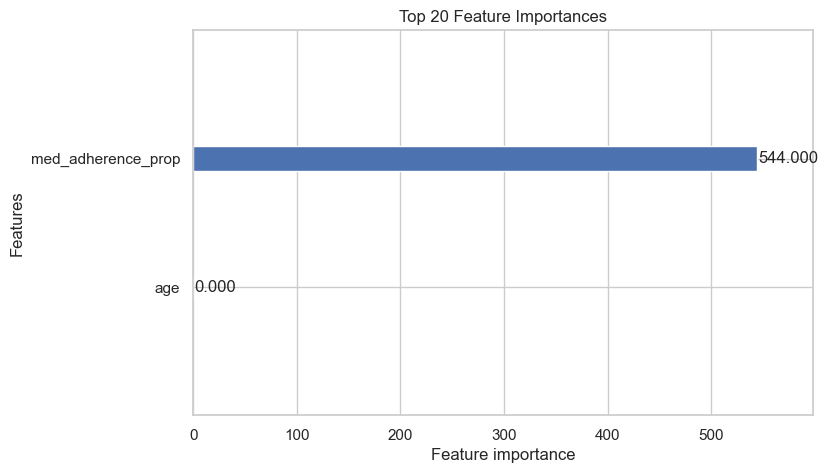

In [26]:
import matplotlib.pyplot as plt
import lightgbm as lgb

lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances")
plt.show()


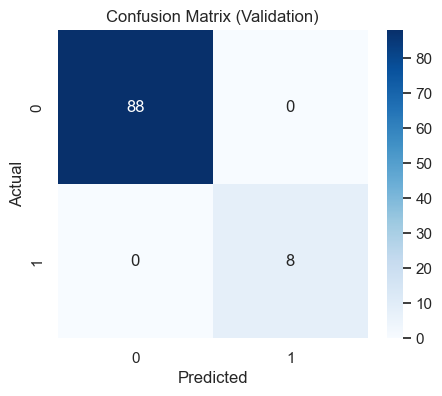

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation)")
plt.show()


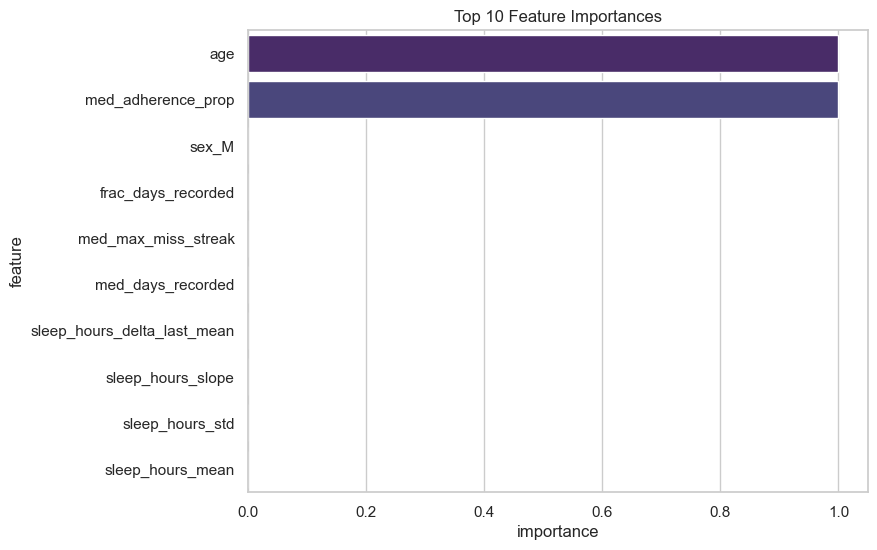

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature importance from LightGBM model
feat_imp = pd.DataFrame({
    "feature": features_list,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(
    x="importance",
    y="feature",
    data=feat_imp.head(10),
    hue="feature",        # fix seaborn warning
    palette="viridis",
    dodge=False,
    legend=False
)
plt.title("Top 10 Feature Importances")
plt.show()


SHAP values shape: (96, 32)


C:\Users\tanuj\AppData\Local\Temp\ipykernel_13132\2899807750.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


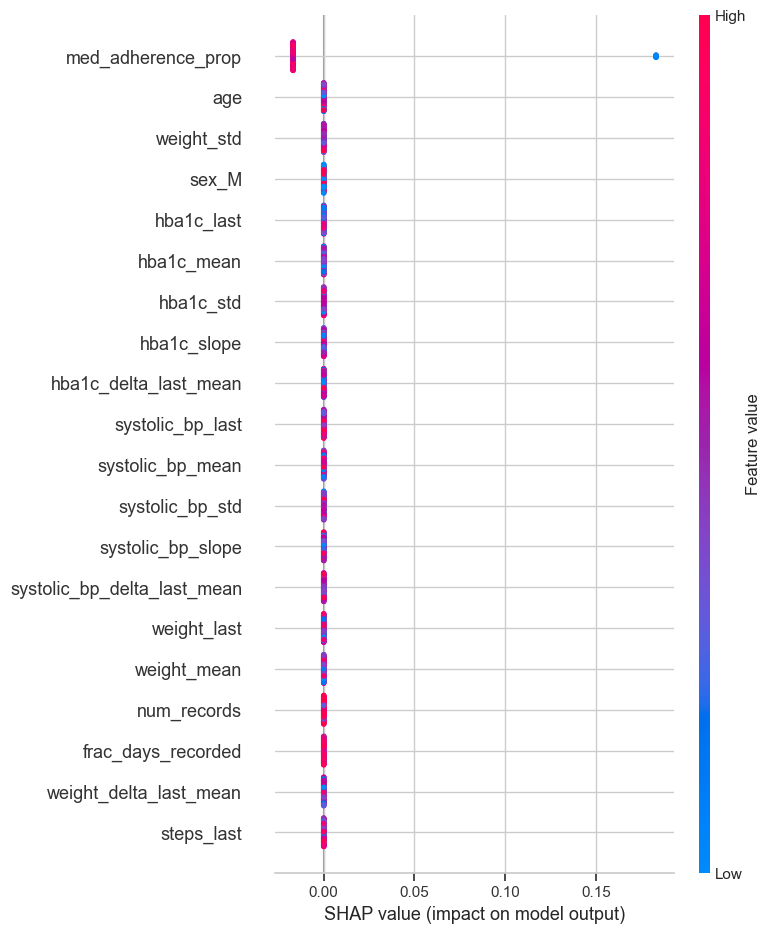

In [37]:
import shap
import warnings

# suppress SHAP user warnings
warnings.filterwarnings("ignore", category=UserWarning, module="shap")

# TreeExplainer
explainer = shap.TreeExplainer(model)

# get shap_values
shap_values = explainer.shap_values(X_val[features_list])

# handle different SHAP outputs for binary classification
if isinstance(shap_values, list):
    # binary classification → take class 1
    shap_values = shap_values[1]  # shape should be (num_samples, num_features)

# ensure it's 2D
print("SHAP values shape:", shap_values.shape)

# summary plot
plt.figure(figsize=(10,6))
shap.summary_plot(
    shap_values,
    X_val[features_list],
    show=True
)


C:\Users\tanuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_force_matplotlib.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)
C:\Users\tanuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_force_matplotlib.py:107: RuntimeWarning: invalid value encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


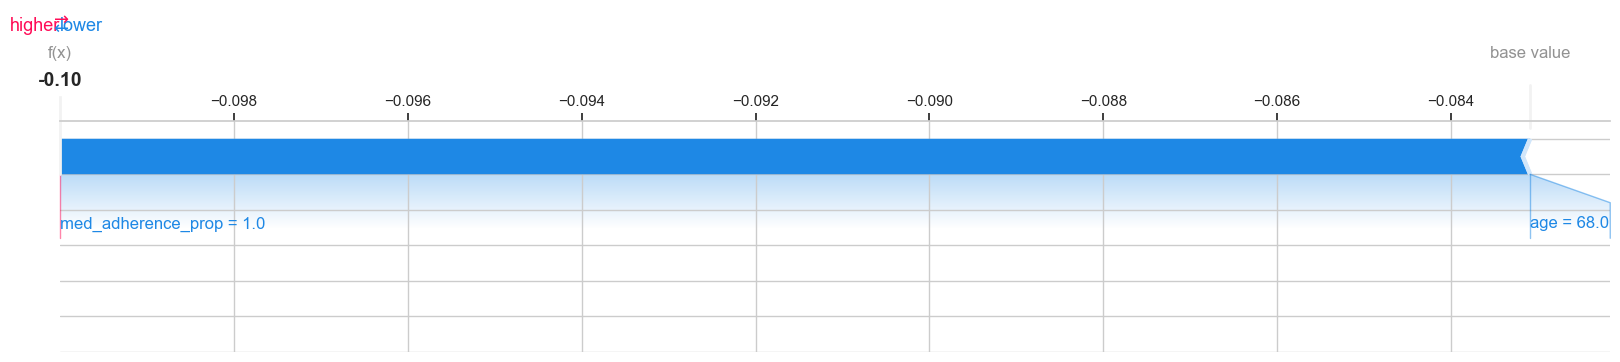

In [38]:
# pick a single patient from X_val
patient_id = X_val.index[0]
X_patient = X_val.loc[patient_id:patient_id, features_list]

# shap values for this patient
shap_values_patient = shap_values[X_val.index.get_loc(patient_id), :]

# force plot (inline with matplotlib)
shap.initjs()  # for HTML rendering in notebooks
shap.force_plot(
    explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
    shap_values_patient,
    X_patient,
    matplotlib=True
)


In [39]:
import joblib
import os

os.makedirs("artifacts", exist_ok=True)

# save model
joblib.dump(model, "artifacts/lgb_model.joblib")

# save features list
joblib.dump(features_list, "artifacts/features_list.joblib")

print("Model and feature list saved in ./artifacts")


Model and feature list saved in ./artifacts


In [40]:
# full predictions with probabilities
data_preds = X_test.copy()
data_preds["pred_prob"] = model.predict_proba(X_test[features_list])[:, 1]
data_preds["true_label"] = y_test

# save
data_preds.to_csv("artifacts/predictions.csv", index=True)
print("Predictions saved for dashboard.")


Predictions saved for dashboard.
